## import


In [6]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

## load


In [7]:
data = pd.read_csv("annotation.csv")

In [8]:
data

Class                            FilePath
0     Abyssinian         Abyssinian\Abyssinian_1.jpg
1     Abyssinian        Abyssinian\Abyssinian_10.jpg
2     Abyssinian       Abyssinian\Abyssinian_100.jpg
3     Abyssinian       Abyssinian\Abyssinian_101.jpg
4     Abyssinian       Abyssinian\Abyssinian_102.jpg
...          ...                                 ...
7385   yorkshire  yorkshire\yorkshire_terrier_95.jpg
7386   yorkshire  yorkshire\yorkshire_terrier_96.jpg
7387   yorkshire  yorkshire\yorkshire_terrier_97.jpg
7388   yorkshire  yorkshire\yorkshire_terrier_98.jpg
7389   yorkshire  yorkshire\yorkshire_terrier_99.jpg

[7390 rows x 2 columns]

In [4]:
data.to_csv('annotation.csv', index=False)

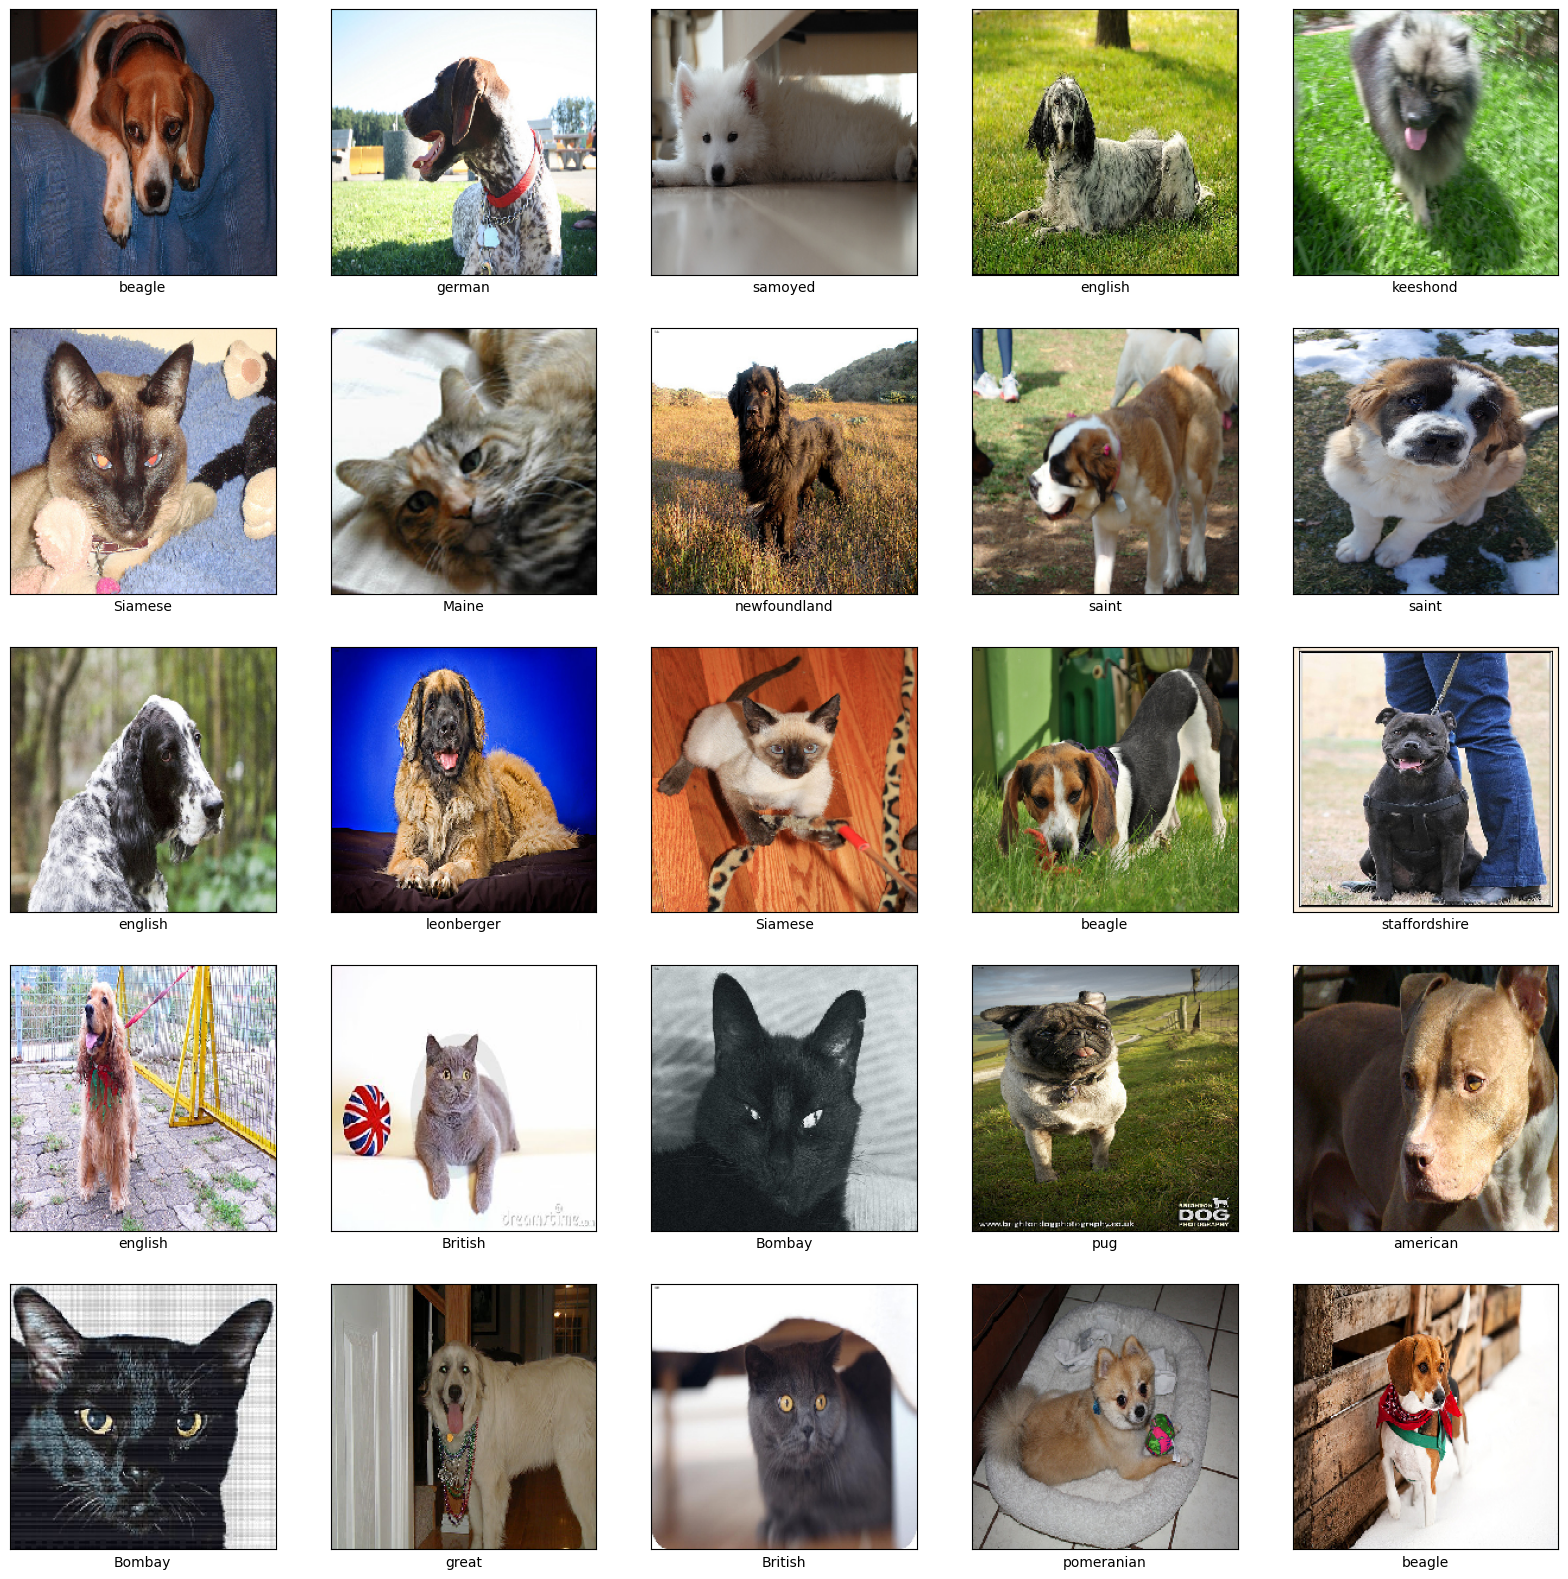

In [11]:
train_path = 'data\\'


plt.figure(figsize=(20,20))
index = np.random.randint(len(data), size=25)
for i in range(25):
    label = data['Class'][index[i]]
    path_img = data['FilePath'][index[i]]
    path_img = train_path +path_img
    
    img = image.load_img(path_img,target_size=(224,224))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(label)
plt.show()

## data split and generation


In [12]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(data, test_size=0.25, stratify=data['Class'])

In [7]:
train

Class                              FilePath
2628    english        english\english_setter_124.jpg
2958     german      german\german_shorthaired_61.jpg
4239  miniature  miniature\miniature_pinscher_134.jpg
5352    Ragdoll                Ragdoll\Ragdoll_51.jpg
4161      Maine               Maine\Maine_Coon_57.jpg
...         ...                                   ...
3588   japanese         japanese\japanese_chin_89.jpg
4078      Maine              Maine\Maine_Coon_189.jpg
2025  chihuahua           chihuahua\chihuahua_121.jpg
1850    British     British\British_Shorthair_157.jpg
1355     Birman                  Birman\Birman_59.jpg

[5542 rows x 2 columns]

In [13]:
train_path = 'data\\'

height, width, channel = (224, 224, 3)
batch_size = 1

train_datagen= ImageDataGenerator(rescale=1.0/255.0,
                              rotation_range=20,
                              width_shift_range=0.01,
                              height_shift_range=0.01,
                              zoom_range=[0.5, 0.9],
                              horizontal_flip=True,
                              fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(train,
                                                   directory = train_path,
                                                   x_col='FilePath',
                                                   y_col='Class',
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   color_mode= 'rgb',
                                                   target_size=(height, width))

valid_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

valid_generator = valid_datagen.flow_from_dataframe(valid,
                                                   directory = train_path,
                                                   x_col='FilePath',
                                                   y_col='Class',
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   color_mode= 'rgb',
                                                   target_size=(height, width))

Found 5542 validated image filenames belonging to 35 classes.
Found 1848 validated image filenames belonging to 35 classes.


In [14]:
pred2label={}
for x in train_generator.class_indices.keys():
    pred2label[train_generator.class_indices[x]] = x

In [17]:
# dict을 csv로 저장
dic = pred2label
df = pd.DataFrame(list(dic.items()), columns=['id', 'breed'])
df.to_csv('submission.csv', index=False)

## modeling


In [1]:
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, InputLayer, Resizing
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.optimizers.legacy import Adam

from keras.models import load_model

In [2]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layers in base_model.layers:
    layers.trainable = False

In [3]:
vgg16 = Sequential()
vgg16.add(base_model)
vgg16.add(GlobalAveragePooling2D())
vgg16.add(Dropout(0.25))
vgg16.add(Dense(512, activation='relu'))
vgg16.add(Dropout(0.3))
vgg16.add(Dense(35, activation='softmax'))

In [4]:
vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 35)                17955     
                                                        

In [5]:
stop = EarlyStopping(patience=1)

# 자동 저장
checkpoint = ModelCheckpoint("./best_vgg16",monitor='val_accuracy',
                            save_weights_only=True, mode='max',verbose=1,save_best_only=True)
callbacks = [stop, checkpoint]

# 모델 컴파일
vgg16.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [15]:
# 모델 훈련
vgg_hist = vgg16.fit(train_generator,
                            validation_data=valid_generator,
                            callbacks=callbacks,
                            verbose=2,
                            epochs=5, 
                               steps_per_epoch=int(0.75 * 7390 / batch_size),
                              validation_steps=int(0.25 * 7390 / batch_size)
                              )

5542/5542 - 109s - loss: 2.9267 - accuracy: 0.1615 - val_loss: 2.3935 - val_accuracy: 0.2727 - 109s/epoch - 20ms/step
